In [390]:
import pandas as pd 
import numpy as np

In [391]:
#read data
df = pd.read_csv('Copy of subscribers.csv')
df.head()

,Unnamed: 0,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,country,attribution_technical,...,trial_end_date,initial_credit_card_declined,join_fee,language,payment_type,num_trial_days,current_sub_TF,payment_period,last_payment,next_payment,cancel_date,trial_completed
0,162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,NaN,False,UAE,facebook,...,2020-02-07 21:44:16,False,NaN,ar,Standard Charter,14,True,1,2020-02-07 21:44:16,2020-06-07 21:44:16,NaN,True
1,380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,70.0,False,UAE,facebook,...,2020-03-15 15:44:35,False,0.3303,ar,NaN,14,True,1,2020-03-15 15:44:35,2020-07-15 15:44:35,NaN,True
2,496617,26844789,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,UAE,organic,...,2019-12-21 16:37:06,False,0.1101,ar,NaN,14,False,0,NaN,NaN,NaN,True
3,356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,30.0,False,UAE,search,...,2020-02-10 16:09:32,False,0.0367,ar,NaN,14,False,0,NaN,NaN,NaN,True
4,681701,26723159,base,4.0,comedy,replace OTT,22.951579,3.0,28.0,False,UAE,discovery,...,2019-10-19 12:57:07,False,0.0367,ar,NaN,14,True,2,2020-02-19 12:57:07,2020-06-19 12:57:07,NaN,True


In [392]:
subscribers_df = df.drop(columns=['Unnamed: 0'])#drop the unnamed column
subscribers_df.head()

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,country,attribution_technical,attribution_survey,...,trial_end_date,initial_credit_card_declined,join_fee,language,payment_type,num_trial_days,current_sub_TF,payment_period,last_payment,next_payment,cancel_date,trial_completed
0,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,NaN,False,UAE,facebook,facebook,...,2020-02-07 21:44:16,False,NaN,ar,Standard Charter,14,True,1,2020-02-07 21:44:16,2020-06-07 21:44:16,NaN,True
1,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,70.0,False,UAE,facebook,facebook,...,2020-03-15 15:44:35,False,0.3303,ar,NaN,14,True,1,2020-03-15 15:44:35,2020-07-15 15:44:35,NaN,True
2,26844789,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,UAE,organic,facebook,...,2019-12-21 16:37:06,False,0.1101,ar,NaN,14,False,0,NaN,NaN,NaN,True
3,29417030,base,NaN,drama,replace OTT,20.051667,NaN,30.0,False,UAE,search,tv,...,2020-02-10 16:09:32,False,0.0367,ar,NaN,14,False,0,NaN,NaN,NaN,True
4,26723159,base,4.0,comedy,replace OTT,22.951579,3.0,28.0,False,UAE,discovery,youtube,...,2019-10-19 12:57:07,False,0.0367,ar,NaN,14,True,2,2020-02-19 12:57:07,2020-06-19 12:57:07,NaN,True


# 1. AB Testing

In [393]:
from scipy import stats                 
from scipy.stats import norm

In [394]:
subscribers_df['plan_type'].value_counts()

base_uae_14_day_trial                227096
high_uae_14_day_trial                   325
low_uae_no_trial                        167
base_eur_14_day_trial                    18
high_sar_14_day_trial                    12
low_gbp_14_day_trial                      4
high_aud_14_day_trial                     2
low_eur_no_trial                          1
base_uae_no_trial_7_day_guarantee         1
low_sar_no_trial                          1
high_jpy_14_day_trial                     1
Name: plan_type, dtype: int64

# Hypothesis Test

In [395]:
def proportion(array_TF):
    return sum(array_TF)/len(array_TF)

In [396]:
def calc_zscore(phat, p_f, n_f):
    z_score_f = (phat-p_f)/((p_f*(1-p_f))/n_f)**0.5     
    return z_score_f

In [397]:
def get_z_crit_value(alpha_f, num_sides_f):
    z_crit_value_f = norm.ppf(1-(alpha_f/num_sides_f))  
    return z_crit_value_f

In [398]:
def get_p_value(zscore_f, num_sides_f):
   
    p_value_f = num_sides_f * min(norm.cdf(zscore_f), 1 - norm.cdf(zscore_f)) 
    return p_value_f

In [399]:
def reject_null(variantA_outcomes_f, variantB_outcomes_f, alpha_f, num_sides_f):
    p_hat_f = proportion(variantB_outcomes_f)
    p_f = proportion(variantA_outcomes_f)
    n_f = len(variantB_outcomes_f)
    z_score = calc_zscore(p_hat_f, p_f, n_f)
    p_value = get_p_value(z_score, num_sides_f)
    z_crit = get_z_crit_value(alpha_f, num_sides_f)
    
    
    if z_score >= z_crit and p_value < alpha_f:
  
        reject_null_TF_f = True
    else:
        reject_null_TF_f = False

    return reject_null_TF_f, z_score, p_value

In [400]:
# set parameters
alpha = 0.05   
num_sides = 1   

# ALL DATA
typeA_outcomes = subscribers_df.loc[subscribers_df['plan_type'] == 'base_uae_14_day_trial', 'current_sub_TF']
typeB_outcomes = subscribers_df.loc[subscribers_df['plan_type'] == 'high_uae_14_day_trial', 'current_sub_TF']

In [401]:
#conduct tests
reject_null_test, z_score, p_value = reject_null(typeA_outcomes, typeB_outcomes, alpha, num_sides)
print('Conversion rate for base_uae_14_day_trial: %3.1f%%' % (proportion(typeA_outcomes)*100))
print('Conversion rate for high_uae_14_day_trial: %3.1f%%' % (proportion(typeB_outcomes)*100))
print('Using all high_uae_14_day_trial, reject null T/F?: %s' % reject_null_test)
print('z-score = %3.2f and p-value = %3.9f%%' % (z_score, p_value*100))

Conversion rate for base_uae_14_day_trial: 57.2%
Conversion rate for high_uae_14_day_trial: 55.1%
Using all high_uae_14_day_trial, reject null T/F?: False
z-score = -0.79 and p-value = 21.437743137%


### Conclusion
We fail to reject the Null Hypothesis states that base_uae_14_day_trail stratgy can improve the conversion of the customers

In [402]:
typeC_outcomes = subscribers_df.loc[subscribers_df['plan_type'] == 'low_uae_no_trial', 'current_sub_TF']

In [403]:
#conduct tests
reject_null_test, z_score, p_value = reject_null(typeA_outcomes, typeC_outcomes, alpha, num_sides)
print('Conversion rate for base_uae_14_day_trial: %3.1f%%' % (proportion(typeA_outcomes)*100))
print('Conversion rate for low_uae_no_trial: %3.1f%%' % (proportion(typeC_outcomes)*100))
print('Using all low_uae_no_trial, reject null T/F?: %s' % reject_null_test)
print('z-score = %3.2f and p-value = %3.9f%%' % (z_score, p_value*100))

Conversion rate for base_uae_14_day_trial: 57.2%
Conversion rate for low_uae_no_trial: 26.9%
Using all low_uae_no_trial, reject null T/F?: False
z-score = -7.92 and p-value = 0.000000000%


### Conclusion
We fail to reject the Null Hypothesis again which also states that base_uae_14_day_trail stratgy can improve the conversion of the customers

# 2. Attribution and Allocation

In [404]:
channel_df = pd.read_csv('Copy of channel_spend_graduate.csv')
channel_df

,channel,date,spend_AED
0,bing,201907,400
1,display,201907,12
2,facebook,201907,9000
3,search,201907,13000
4,youtube,201907,90
5,bing,201908,900
6,display,201908,20
7,facebook,201908,13000
8,search,201908,18500
9,youtube,201908,180


In [405]:
channel_df = pd.read_csv('Copy of channel_spend_graduate.csv')
channel = pd.DataFrame()
channel['channel'] = channel_df.channel.copy()
channel['spend_AED'] = channel_df.spend_AED.copy()
channel.head()

,channel,spend_AED
0,bing,400
1,display,12
2,facebook,9000
3,search,13000
4,youtube,90


In [406]:
spend = channel.groupby('channel').sum('spend_AED')
spend

,spend_AED
channel,
bing,10800
display,366
facebook,113500
search,222500
youtube,8730


# Average CAC

In [407]:
subscribers_df['attribution_technical'].value_counts()

facebook                   80251
email                      25690
search                     25306
organic                    22013
brand sem intent google    18524
google_organic             10691
affiliate                   9894
email_blast                 7277
pinterest                   6065
referral                    5170
facebook_organic            3272
discovery                   2571
brand sem intent bing       2231
other                       1786
display                     1407
bing                        1146
internal                    1122
podcast                      985
youtube                      913
bing_organic                 369
vod                          297
ott                          158
direct_mail                  139
quora                        100
samsung                       86
appstore                      44
criteo                        44
pinterest_organic             30
influencer                    21
playstore                     12
content_gr

In [408]:
attr_tech = subscribers_df[['attribution_technical']].value_counts().to_frame()
attr_tech = attr_tech.reset_index()
attr_tech.columns = ['channel','user']
attr_tech

,channel,user
0,facebook,80251
1,email,25690
2,search,25306
3,organic,22013
4,brand sem intent google,18524
5,google_organic,10691
6,affiliate,9894
7,email_blast,7277
8,pinterest,6065
9,referral,5170


In [409]:
attr_tech = pd.merge(attr_tech, spend, on=['channel'])
attr_tech

,channel,user,spend_AED
0,facebook,80251,113500
1,search,25306,222500
2,display,1407,366
3,bing,1146,10800
4,youtube,913,8730


In [410]:
attr_tech['avg_CAC'] = attr_tech['spend_AED']/attr_tech['user']
attr_tech

,channel,user,spend_AED,avg_CAC
0,facebook,80251,113500,1.414313
1,search,25306,222500,8.792381
2,display,1407,366,0.260128
3,bing,1146,10800,9.424084
4,youtube,913,8730,9.561884


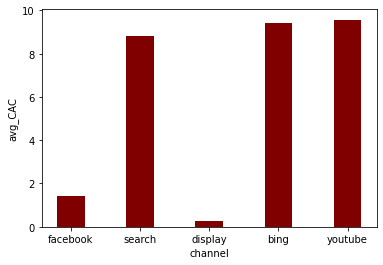

In [411]:
from matplotlib import pyplot as plt
plt.bar(attr_tech['channel'], attr_tech['avg_CAC'], color ='maroon',
        width = 0.4)
 
plt.xlabel("channel")
plt.ylabel("avg_CAC")
plt.show()

### Conclusion
We should allocate the most budget into the display channel and also the facebook channel based on the average CAC.
I calcualted the marginal CAC in EXCEL and I showed the graph in the slides.

# Churn

In [412]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from matplotlib import pyplot as plt
import numpy as np
import copy
import math

pd.options.display.max_columns = 25

In [413]:
subs_df = subscribers_df.copy()
subs_df.info() 
subs_df = subs_df.drop(['language','country','months_per_bill_period','plan_type',
                        'monthly_price','discount_price','account_creation_date',
                        'trial_end_date','last_payment','next_payment',
                        'payment_type','initial_credit_card_declined','cancel_date'],axis = 1)
subs_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227628 entries, 0 to 227627
Data columns (total 30 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   subid                         227628 non-null  int64  
 1   package_type                  192054 non-null  object 
 2   num_weekly_services_utilized  117178 non-null  float64
 3   preferred_genre               191302 non-null  object 
 4   intended_use                  224079 non-null  object 
 5   weekly_consumption_hour       189698 non-null  float64
 6   num_ideal_streaming_services  115458 non-null  float64
 7   age                           192459 non-null  float64
 8   male_TF                       227359 non-null  object 
 9   country                       227628 non-null  object 
 10  attribution_technical         227628 non-null  object 
 11  attribution_survey            224984 non-null  object 
 12  op_sys                        214253 non-nul

In [414]:
subs_df.package_type.fillna(0, inplace=True)
subs_df.num_weekly_services_utilized.fillna(0, inplace=True)
subs_df.preferred_genre.fillna(0, inplace=True)
subs_df.intended_use.fillna(0, inplace=True)
subs_df.weekly_consumption_hour.fillna(0, inplace=True)
subs_df.num_ideal_streaming_services .fillna(0, inplace=True)
subs_df.age.fillna(0, inplace=True)
subs_df.male_TF.fillna(0, inplace=True)
subs_df.attribution_survey.fillna(0, inplace=True)
subs_df.op_sys.fillna(0, inplace=True)
subs_df.join_fee.fillna(0, inplace=True)
subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227628 entries, 0 to 227627
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   subid                         227628 non-null  int64  
 1   package_type                  227628 non-null  object 
 2   num_weekly_services_utilized  227628 non-null  float64
 3   preferred_genre               227628 non-null  object 
 4   intended_use                  227628 non-null  object 
 5   weekly_consumption_hour       227628 non-null  float64
 6   num_ideal_streaming_services  227628 non-null  float64
 7   age                           227628 non-null  float64
 8   male_TF                       227628 non-null  object 
 9   attribution_technical         227628 non-null  object 
 10  attribution_survey            227628 non-null  object 
 11  op_sys                        227628 non-null  object 
 12  join_fee                      227628 non-nul

In [415]:
subs_df['age'][subs_df['age'] > 100] = 0
subs_df['join_fee'][subs_df['join_fee'] < 0] = 0
subs_df['weekly_consumption_hour'][subs_df['weekly_consumption_hour'] < 0] = 0
subs_df['num_ideal_streaming_services'][subs_df['num_ideal_streaming_services'] < 0] = 0

/var/folders/_4/dp_ydqpd18q1gv0v8bs6y9140000gn/T/ipykernel_1363/349627264.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subs_df['age'][subs_df['age'] > 100] = 0
/var/folders/_4/dp_ydqpd18q1gv0v8bs6y9140000gn/T/ipykernel_1363/349627264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subs_df['join_fee'][subs_df['join_fee'] < 0] = 0
/var/folders/_4/dp_ydqpd18q1gv0v8bs6y9140000gn/T/ipykernel_1363/349627264.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [416]:
subs_df['male_TF'] = subs_df.male_TF.apply(lambda x: int(x))
subs_df['churn_TF'] = subs_df.current_sub_TF.apply(lambda x: 1 if x == False else 0)
subs_df['trial_completed'] = subs_df.trial_completed.apply(lambda x: int(x))
subs_df

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,attribution_technical,attribution_survey,op_sys,join_fee,num_trial_days,current_sub_TF,payment_period,trial_completed,churn_TF
0,21724479,economy,0.0,comedy,access to exclusive content,0.000000,0.0,0.0,0,facebook,facebook,Android,0.0000,14,True,1,1,0
1,23383224,base,0.0,comedy,access to exclusive content,22.951579,0.0,70.0,0,facebook,facebook,0,0.3303,14,True,1,1,0
2,26844789,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,1,organic,facebook,iOS,0.1101,14,False,0,1,1
3,29417030,base,0.0,drama,replace OTT,20.051667,0.0,30.0,0,search,tv,Android,0.0367,14,False,0,1,1
4,26723159,base,4.0,comedy,replace OTT,22.951579,3.0,28.0,0,discovery,youtube,iOS,0.0367,14,True,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227623,21434712,enhanced,3.0,comedy,supplement OTT,28.751405,2.0,38.0,0,facebook,facebook_organic,iOS,0.3303,14,True,1,1,0
227624,25843074,enhanced,2.0,comedy,replace OTT,27.301448,2.0,49.0,0,google_organic,referral,iOS,0.3303,14,True,1,1,0
227625,24799085,base,0.0,comedy,access to exclusive content,31.651317,0.0,45.0,0,facebook,facebook,iOS,0.0367,14,True,1,1,0
227626,21308040,base,0.0,comedy,access to exclusive content,0.000000,0.0,0.0,0,facebook,facebook,iOS,0.0000,14,True,1,1,0


In [417]:
subs_df = pd.get_dummies(data=subs_df, columns=['package_type', 'preferred_genre','intended_use',
                                                'attribution_technical','attribution_survey','op_sys'])

In [418]:
subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227628 entries, 0 to 227627
Data columns (total 83 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   subid                                          227628 non-null  int64  
 1   num_weekly_services_utilized                   227628 non-null  float64
 2   weekly_consumption_hour                        227628 non-null  float64
 3   num_ideal_streaming_services                   227628 non-null  float64
 4   age                                            227628 non-null  float64
 5   male_TF                                        227628 non-null  int64  
 6   join_fee                                       227628 non-null  float64
 7   num_trial_days                                 227628 non-null  int64  
 8   current_sub_TF                                 227628 non-null  bool   
 9   payment_period                       

In [419]:
print(subs_df.columns)

Index(['subid', 'num_weekly_services_utilized', 'weekly_consumption_hour',
       'num_ideal_streaming_services', 'age', 'male_TF', 'join_fee',
       'num_trial_days', 'current_sub_TF', 'payment_period', 'trial_completed',
       'churn_TF', 'package_type_0', 'package_type_base',
       'package_type_economy', 'package_type_enhanced', 'preferred_genre_0',
       'preferred_genre_comedy', 'preferred_genre_drama',
       'preferred_genre_international', 'preferred_genre_other',
       'preferred_genre_regional', 'intended_use_0',
       'intended_use_access to exclusive content', 'intended_use_education',
       'intended_use_expand international access',
       'intended_use_expand regional access', 'intended_use_other',
       'intended_use_replace OTT', 'intended_use_supplement OTT',
       'attribution_technical_affiliate', 'attribution_technical_appstore',
       'attribution_technical_bing', 'attribution_technical_bing_organic',
       'attribution_technical_brand sem intent bing'

In [420]:
subs_df.head()

,subid,num_weekly_services_utilized,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,join_fee,num_trial_days,current_sub_TF,payment_period,trial_completed,churn_TF,...,attribution_survey_pinterest,attribution_survey_podcast,attribution_survey_public_radio,attribution_survey_referral,attribution_survey_search,attribution_survey_sirius xm,attribution_survey_social_organic,attribution_survey_tv,attribution_survey_youtube,op_sys_0,op_sys_Android,op_sys_iOS
0,21724479,0.0,0.000000,0.0,0.0,0,0.0000,14,True,1,1,0,...,0,0,0,0,0,0,0,0,0,0,1,0
1,23383224,0.0,22.951579,0.0,70.0,0,0.3303,14,True,1,1,0,...,0,0,0,0,0,0,0,0,0,1,0,0
2,26844789,3.0,36.001186,2.0,25.0,1,0.1101,14,False,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,1
3,29417030,0.0,20.051667,0.0,30.0,0,0.0367,14,False,0,1,1,...,0,0,0,0,0,0,0,1,0,0,1,0
4,26723159,4.0,22.951579,3.0,28.0,0,0.0367,14,True,2,1,0,...,0,0,0,0,0,0,0,0,1,0,0,1


In [421]:
# ------ DEFINE FUNCTIONS -----
def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = copy.deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f['churn_TF'] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['churn_TF'] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['churn_TF'] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance

    # make offer under lpm predictions for select threshold
    df_f['make_offer_lpm'] = (df_f['prob_churn_lpm'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_lpm'] = (df_f['make_offer_lpm'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_lpm_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_lpm'], 'price_lpm_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    # make offer under logit predictions for select threshold
    df_f['make_offer_logit'] = (df_f['prob_churn_logit'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_logit'] = (df_f['make_offer_logit'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_logit_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_logit'], 'price_logit_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact


def get_gini_info(actual, pred_prob):
    # format[[obs0_pred0, obs0_pred1], [obs1_pred0, obs1_pred1]]; rows (i) are observed, columns (j) are predicted
    confusion_matrix_list = list()
    for t in [x / 100 for x in range(0, 100, 33)]:
        pred = [1 if (x > t) else 0 for x in pred_prob]
        confusion_matrix_list.append(confusion_matrix(actual, pred))
        # confusion_matrix_list.append(model.pred_table(threshold=t))

    # create Gini coefficient plots
    false_positives = list()
    true_positives = list()
    for t in confusion_matrix_list:
        true_positives.append(t[1, 1])
        false_positives.append(t[0, 1])

    return confusion_matrix_list, false_positives, true_positives

In [422]:
# ----- READ IN DATA -----
df_train, df_test = model_selection.train_test_split(subs_df, test_size=0.3)

In [423]:
# ----- FIT CHURN MODEL ------
y_col_name = 'churn_TF' # specify which column contains outcome variable y. Needs to be coded as binary True/False or 0/1
x_col_name = ['subid', 'num_weekly_services_utilized', 'weekly_consumption_hour',
       'num_ideal_streaming_services', 'age', 'male_TF', 'join_fee',
       'num_trial_days', 'payment_period', 'trial_completed',
       'package_type_0', 'package_type_base',
       'package_type_economy', 'package_type_enhanced', 'preferred_genre_0',
       'preferred_genre_comedy', 'preferred_genre_drama',
       'preferred_genre_international', 'preferred_genre_other',
       'preferred_genre_regional', 'intended_use_0',
       'intended_use_access to exclusive content', 'intended_use_education',
       'intended_use_expand international access',
       'intended_use_expand regional access', 'intended_use_other',
       'intended_use_replace OTT', 'intended_use_supplement OTT',
       'attribution_technical_affiliate', 'attribution_technical_appstore',
       'attribution_technical_bing', 'attribution_technical_bing_organic',
       'attribution_technical_brand sem intent bing',
       'attribution_technical_brand sem intent google',
       'attribution_technical_content_greatist',
       'attribution_technical_criteo', 'attribution_technical_direct_mail',
       'attribution_technical_discovery', 'attribution_technical_display',
       'attribution_technical_email', 'attribution_technical_email_blast',
       'attribution_technical_facebook',
       'attribution_technical_facebook_organic',
       'attribution_technical_google_organic',
       'attribution_technical_influencer', 'attribution_technical_internal',
       'attribution_technical_organic', 'attribution_technical_other',
       'attribution_technical_ott', 'attribution_technical_pinterest',
       'attribution_technical_pinterest_organic',
       'attribution_technical_playstore', 'attribution_technical_podcast',
       'attribution_technical_quora', 'attribution_technical_referral',
       'attribution_technical_samsung', 'attribution_technical_search',
       'attribution_technical_tv', 'attribution_technical_twitter',
       'attribution_technical_vod', 'attribution_technical_youtube',
       'attribution_survey_0', 'attribution_survey_affiliate',
       'attribution_survey_amfm_radio', 'attribution_survey_direct_mail',
       'attribution_survey_facebook', 'attribution_survey_facebook_organic',
       'attribution_survey_other', 'attribution_survey_ott',
       'attribution_survey_pinterest', 'attribution_survey_podcast',
       'attribution_survey_public_radio', 'attribution_survey_referral',
       'attribution_survey_search', 'attribution_survey_sirius xm',
       'attribution_survey_social_organic', 'attribution_survey_tv',
       'attribution_survey_youtube', 'op_sys_0', 'op_sys_Android',
       'op_sys_iOS']   # list of x covariates
add_constant_TF = True

In [424]:
# --- preprocess data for model routine format requirements
if add_constant_TF:
    x_col_name.append('const')
    df_train = sm.add_constant(df_train)
    df_test = sm.add_constant(df_test)

In [425]:
# --- fit linear probability model
lpm_model = sm.OLS(endog=df_train[y_col_name], exog=df_train[x_col_name])
lpm_results = lpm_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(lpm_results.summary())


RESULTS OF LOGIT MODEL FITTING

                            OLS Regression Results                            
Dep. Variable:               churn_TF   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     5281.
Date:                Wed, 21 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:22:45   Log-Likelihood:                -14475.
No. Observations:              159339   AIC:                         2.910e+04
Df Residuals:                  159263   BIC:                         2.986e+04
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [426]:
# --- fit logistic regression
logit_model = sm.Logit(endog=df_train[y_col_name], exog=df_train[x_col_name])
logit_results = logit_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(logit_results.summary())

         Current function value: 0.164124
         Iterations: 35

RESULTS OF LOGIT MODEL FITTING

                           Logit Regression Results                           
Dep. Variable:               churn_TF   No. Observations:               159339
Model:                          Logit   Df Residuals:                   159263
Method:                           MLE   Df Model:                           75
Date:                Wed, 21 Dec 2022   Pseudo R-squ.:                  0.7596
Time:                        22:22:48   Log-Likelihood:                -26151.
converged:                      False   LL-Null:                   -1.0879e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
subid                                    

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


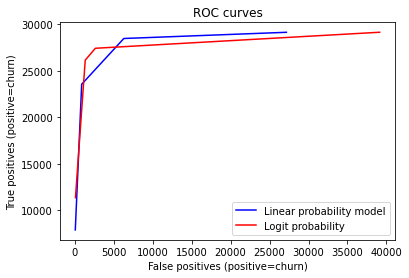

In [427]:
# ----- EVALUATE MODEL PERFORMANCE -----
# --- evaluate model predictions on test set graphically
df_test['prob_churn_lpm'] = lpm_results.predict(df_test[x_col_name])
df_test['prob_churn_logit'] = logit_results.predict(df_test[x_col_name])

# --- evaluate model predictions using numerical quantification (ROC curves)
# make confusion matrices
logit_conf_mat, logit_false_positives, logit_true_positives = get_gini_info(df_test['churn_TF'], df_test['prob_churn_logit'])
lpm_conf_mat, lpm_false_positives, lpm_true_positives = get_gini_info(df_test['churn_TF'], df_test['prob_churn_lpm'])

# plot ROC curves
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(lpm_false_positives, lpm_true_positives, 'b-')
ax1.plot(logit_false_positives, logit_true_positives, 'r-')
plt.title('ROC curves')
plt.xlabel('False positives (positive=churn)')
plt.ylabel('True positives (positive=churn)')
plt.legend(labels=['Linear probability model', 'Logit probability'])

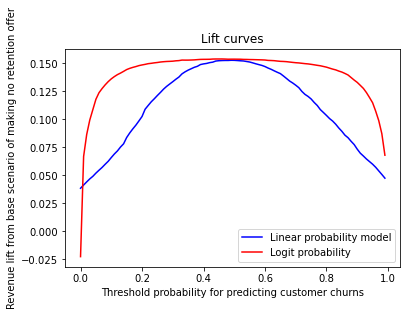

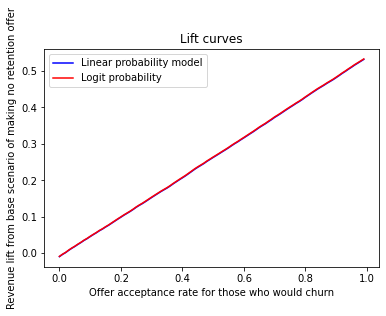

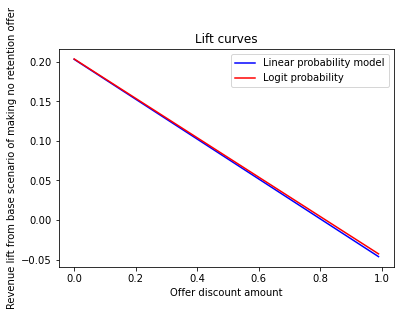

In [428]:
# ----- TEST RETENTION OFFER SCENARIOS -----
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.3
threshold = 0.5
base_price = 4.7343
discount_amount = 0.2
cases = ['no_offer', 'lpm_offer', 'logit_offer']

# draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
df_test['random_draws'] = np.random.random(df_test.shape[0])

# base assessment
df_test, df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

# test sensitivity to acceptance rate for churners
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind

# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind

# --- plot lift curves
# Threshold sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['lpm_offer'], 'b-')
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# Acceptance rate sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['lpm_offer'], 'b-')
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer acceptance rate for those who would churn')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# Discount amount sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['lpm_offer'], 'b-')
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

In [429]:
df_impact

,subs,revenue,lift_from_no_offer
no_offer,39132,185262.6276,0.0
lpm_offer,47077,213544.38894,0.152658
logit_offer,47094,213739.4421,0.153711
